In [1]:
%env CUDA_VISIBLE_DEVICES=1 # set device number

from typing import Union, Tuple, List, Dict
from PIL import Image
import torch
from diffusers import DDIMScheduler, DDIMInverseScheduler
from prompt_to_prompt.pipeline_stable_diffusion_nmg import NMGPipeline
from prompt_to_prompt.ptp_utils import (
    AttentionRefine,
    AttentionReplace,
    LocalBlend,
    AttentionReweight,
    get_word_inds,
)

env: CUDA_VISIBLE_DEVICES=1 # set device number


In [2]:
def get_equalizer(text: str,
                  word_select: Union[int, Tuple[int, ...]],
                  values: Union[List[float], Tuple[float, ...]],
                  tokenizer):
    
    if type(word_select) is int or type(word_select) is str:
        word_select = (word_select,)
    equalizer = torch.ones(1, 77)
    
    for word, val in zip(word_select, values):
        inds = get_word_inds(text, word, tokenizer)
        equalizer[:, inds] = val
    return equalizer

def make_controller(prompts: List[str],
                    is_replace_controller: bool,
                    cross_replace_steps: Dict[str, float],
                    self_replace_steps: float,
                    blend_word=None,
                    equilizer_params=None,
                    num_steps=None,
                    tokenizer=None,
                    device=None):
    if blend_word is None:
        lb = None
    else:
        lb = LocalBlend(prompts, num_steps, blend_word, tokenizer=tokenizer, device=device)
    if is_replace_controller:
        controller = AttentionReplace(prompts, num_steps, cross_replace_steps=cross_replace_steps, 
                self_replace_steps=self_replace_steps, local_blend=lb, tokenizer=tokenizer, device=device)
    else:
        controller = AttentionRefine(prompts, num_steps, cross_replace_steps=cross_replace_steps,
                self_replace_steps=self_replace_steps, local_blend=lb, tokenizer=tokenizer, device=device)
    if equilizer_params is not None:
        eq = get_equalizer(prompts[1], equilizer_params["words"], equilizer_params["values"], tokenizer=tokenizer)
        controller = AttentionReweight(prompts, num_steps, cross_replace_steps=cross_replace_steps,
                self_replace_steps=self_replace_steps, equalizer=eq, local_blend=lb, controller=controller,
                tokenizer=tokenizer, device=device)
    return controller

In [3]:
NUM_DIFFUSION_STEPS = 50

# load stable diffusion
model_ckpt = "CompVis/stable-diffusion-v1-4"
pipe = NMGPipeline.from_pretrained(model_ckpt, torch_dtype=torch.float16)

# set scheduler and invere scheduler
pipe.scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)
pipe.inverse_scheduler = DDIMInverseScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_zero=False)
pipe = pipe.to('cuda')

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


## Object Swap

In [4]:
# load image
img_path = 'images/img1.jpg'
img = Image.open(img_path)

# set source and target prompt
src_prompt = "a cat sitting on a table next to a vase of flowers"
trg_prompt = "a tiger sitting on a table next to a vase of flowers"
prompts = [src_prompt, trg_prompt]

# inversion
inv_output = pipe.invert(src_prompt, img, num_inference_steps=NUM_DIFFUSION_STEPS)
forward_latents = inv_output.latents_list

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

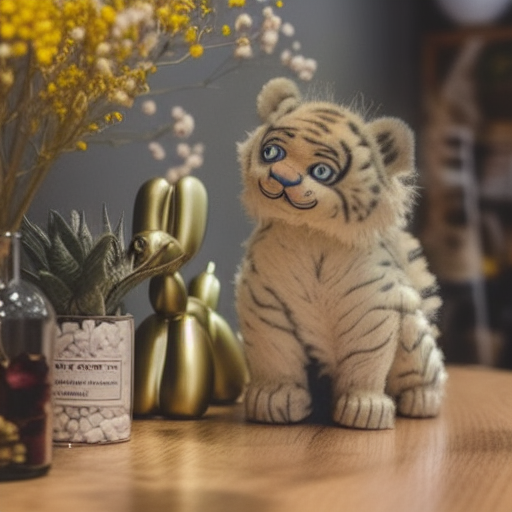

In [5]:
# set prompt-to-prompt paremeters
cross_replace_steps = 0.8
self_replace_steps = 0.7
src_text = "cat"
trg_text = "tiger"
blend_word = (((src_text,), (trg_text,)))
eq_params = {"words": (trg_text,), "values": (2,)}
controller = make_controller(prompts,
                            True,
                            cross_replace_steps,
                            self_replace_steps,
                            blend_word,
                            eq_params,
                            NUM_DIFFUSION_STEPS,
                            pipe.tokenizer,
                            pipe.device)

# set NMG parameters
grad_scale = 5000 # gradient scale
guidance_noise_map = 10 # NMG scale
guidance_text = 10 # CFG scale
noise_cond_loss_type = 'l1' # choices=['l1', 'l2', 'smooth_l1']

# NMG with prompt-to-prompt
with torch.autocast("cuda"): 
    outputs = pipe(
        prompt=prompts,
        controller=controller,
        num_inference_steps=NUM_DIFFUSION_STEPS,
        grad_scale=grad_scale,
        guidance_noise_map=guidance_noise_map,
        guidance_text=guidance_text,
        noise_cond_loss_type=noise_cond_loss_type,
        forward_latents=forward_latents
    )
outputs.images[1]

## Contextual Change

In [6]:
# load image
img_path = 'images/img2.jpg'
img = Image.open(img_path)

# set source and target prompt
src_prompt = "a woman in the forest"
trg_prompt = "a woman in the desert"
prompts = [src_prompt, trg_prompt]

# inversion
inv_output = pipe.invert(src_prompt, img, num_inference_steps=NUM_DIFFUSION_STEPS)
forward_latents = inv_output.latents_list

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

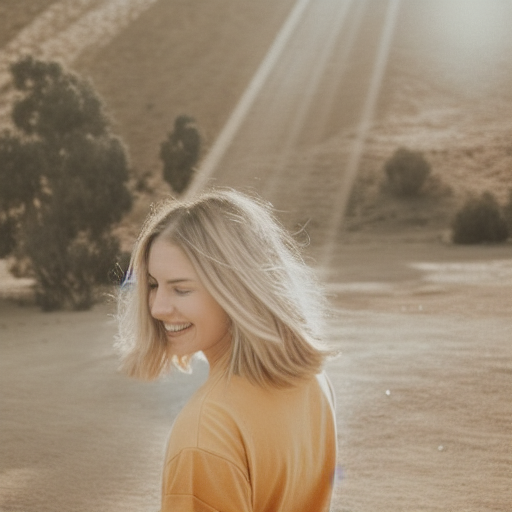

In [7]:
# set prompt-to-prompt paremeters
cross_replace_steps = 0.8
self_replace_steps = 0.5
src_text = "forest"
trg_text = "desert"
blend_word = (((src_text,), (trg_text,)))
eq_params = {"words": (trg_text,), "values": (2,)}
controller = make_controller(prompts,
                            True,
                            cross_replace_steps,
                            self_replace_steps,
                            blend_word,
                            eq_params,
                            NUM_DIFFUSION_STEPS,
                            pipe.tokenizer,
                            pipe.device)

# set NMG parameters
grad_scale = 5000 # gradient scale
guidance_noise_map = 10 # NMG scale
guidance_text = 10 # CFG scale
noise_cond_loss_type = 'l1' # choices=['l1', 'l2', 'smooth_l1']

# NMG with prompt-to-prompt
with torch.autocast("cuda"): 
    outputs = pipe(
        prompt=prompts,
        controller=controller,
        num_inference_steps=NUM_DIFFUSION_STEPS,
        grad_scale=grad_scale,
        guidance_noise_map=guidance_noise_map,
        guidance_text=guidance_text,
        noise_cond_loss_type=noise_cond_loss_type,
        forward_latents=forward_latents
    )
outputs.images[1]

## Face Attribute Editing

In [8]:
# load image
img_path = 'images/img3.jpg'
img = Image.open(img_path)

# set source and target prompt
src_prompt = "a young man standing in front of a building"
trg_prompt = "a young man standing in front of a building, smiling"
prompts = [src_prompt, trg_prompt]

# inversion
inv_output = pipe.invert(src_prompt, img, num_inference_steps=NUM_DIFFUSION_STEPS)
forward_latents = inv_output.latents_list

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

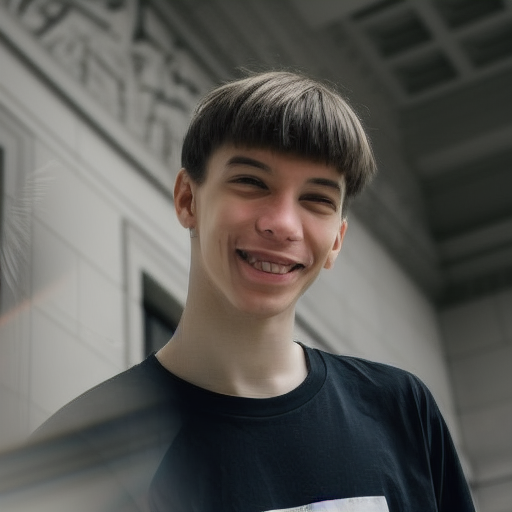

In [9]:
# set prompt-to-prompt paremeters
cross_replace_steps = 0.8
self_replace_steps = 0.7
local_prompt = "man"
trg_text = "smiling"
blend_word = (((local_prompt,), (local_prompt,)))
eq_params = {"words": (trg_text,), "values": (2,)}
controller = make_controller(prompts,
                            False,
                            cross_replace_steps,
                            self_replace_steps,
                            blend_word,
                            eq_params,
                            NUM_DIFFUSION_STEPS,
                            pipe.tokenizer,
                            pipe.device)

# set NMG parameters
grad_scale = 5000 # gradient scale
guidance_noise_map = 10 # NMG scale
guidance_text = 10 # CFG scale
noise_cond_loss_type = 'l1' # choices=['l1', 'l2', 'smooth_l1']

# NMG with prompt-to-prompt
with torch.autocast("cuda"): 
    outputs = pipe(
        prompt=prompts,
        controller=controller,
        num_inference_steps=NUM_DIFFUSION_STEPS,
        grad_scale=grad_scale,
        guidance_noise_map=guidance_noise_map,
        guidance_text=guidance_text,
        noise_cond_loss_type=noise_cond_loss_type,
        forward_latents=forward_latents
    )
outputs.images[1]

## Color Change

In [10]:
# load image
img_path = 'images/img4.jpg'
img = Image.open(img_path)

# set source and target prompt
src_prompt = "a maroon vans on a yellow background"
trg_prompt = "a black vans on a yellow background"
prompts = [src_prompt, trg_prompt]

# inversion
inv_output = pipe.invert(src_prompt, img, num_inference_steps=NUM_DIFFUSION_STEPS)
forward_latents = inv_output.latents_list

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


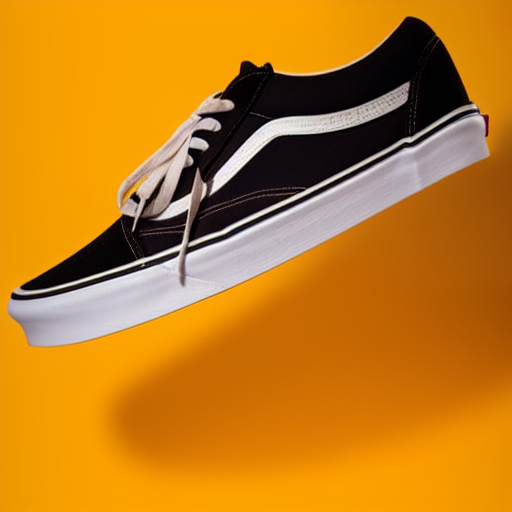

In [11]:
# set prompt-to-prompt paremeters
cross_replace_steps = 0.8
self_replace_steps = 0.7
src_text = "maroon"
trg_text = "black"
blend_word = (((src_text,), (trg_text,)))
eq_params = {"words": (trg_text,), "values": (2,)}
controller = make_controller(prompts,
                            True,
                            cross_replace_steps,
                            self_replace_steps,
                            blend_word,
                            eq_params,
                            NUM_DIFFUSION_STEPS,
                            pipe.tokenizer,
                            pipe.device)

# set NMG parameters
grad_scale = 5000 # gradient scale
guidance_noise_map = 10 # NMG scale
guidance_text = 10 # CFG scale
noise_cond_loss_type = 'l1' # choices=['l1', 'l2', 'smooth_l1']

# NMG with prompt-to-prompt
with torch.autocast("cuda"): 
    outputs = pipe(
        prompt=prompts,
        controller=controller,
        num_inference_steps=NUM_DIFFUSION_STEPS,
        grad_scale=grad_scale,
        guidance_noise_map=guidance_noise_map,
        guidance_text=guidance_text,
        noise_cond_loss_type=noise_cond_loss_type,
        forward_latents=forward_latents
    )
outputs.images[1]

## Global Editing

In [12]:
# load image
img_path = 'images/img5.jpg'
img = Image.open(img_path)

# set source and target prompt
src_prompt = "a large elk standing on top of a lush green field"
trg_prompt = "a large elk standing on top of a lush green field, oil painting"
prompts = [src_prompt, trg_prompt]

# inversion
inv_output = pipe.invert(src_prompt, img, num_inference_steps=NUM_DIFFUSION_STEPS)
forward_latents = inv_output.latents_list

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

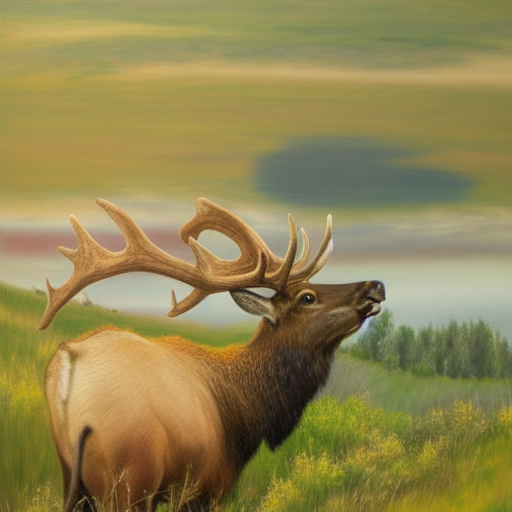

In [13]:
# set prompt-to-prompt paremeters
cross_replace_steps = 0.8
self_replace_steps = 0.6
blend_word = None
eq_params = {"words": ("oil painting",), "values": (3,)}
controller = make_controller(prompts,
                            False,
                            cross_replace_steps,
                            self_replace_steps,
                            blend_word,
                            eq_params,
                            NUM_DIFFUSION_STEPS,
                            pipe.tokenizer,
                            pipe.device)

# set NMG parameters
grad_scale = 5000 # gradient scale
guidance_noise_map = 10 # NMG scale
guidance_text = 10 # CFG scale
noise_cond_loss_type = 'l1' # choices=['l1', 'l2', 'smooth_l1']

# NMG with prompt-to-prompt
with torch.autocast("cuda"): 
    outputs = pipe(
        prompt=prompts,
        controller=controller,
        num_inference_steps=NUM_DIFFUSION_STEPS,
        grad_scale=grad_scale,
        guidance_noise_map=guidance_noise_map,
        guidance_text=guidance_text,
        noise_cond_loss_type=noise_cond_loss_type,
        forward_latents=forward_latents
    )
outputs.images[1]